In [ ]:
import os
import numpy as np
from osgeo import gdal
from tensorflow import keras
import tensorflow as tf
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 10)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

In [ ]:
BASE_PATH = "./Input/final_dataset"
IMAGE_PATH = os.path.join(BASE_PATH, "raw_images")
LABEL_PATH = os.path.join(BASE_PATH, "ground_truth")

In [17]:
def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays.
    
    The following keys are used:
    sat -- satellite image
    bldg -- for the building locations reference image
    road -- for the road locations reference image
    """
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        fname, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = fname
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles


def visualize_labels(labels, fig_width=15, fig_height=12):
    """Visualize the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled image")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["Other", "Informal Settlements"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(data, title, fig_width=15, fig_height=12):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:-1]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

image_tiles = fetch_tiles(IMAGE_PATH)
label_tiles = fetch_tiles(LABEL_PATH)


In [18]:
# visualize_data(image_tiles["tile_train_1"], "Sample training image tile 1")
# visualize_labels(label_tiles["gt_train_1"])

In [19]:
label_tiles.keys(), image_tiles.keys()

(dict_keys(['gt_test_1', 'gt_train_1', 'gt_train_2', 'gt_train_3', 'gt_valid_1']),
 dict_keys(['tile_test_1', 'tile_train_1', 'tile_train_2', 'tile_train_3', 'tile_valid_1']))

In [20]:
PATCHSIZE = 128
NBANDS = image_tiles["tile_train_1"].shape[-1]


def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.nan_to_num(tocat, nan=np.nanmedian(tocat))
            tocat[tocat < -1] = np.median(tocat)
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples


Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# # sample each training tile systematically in a gridwise manner
# train_areas_x = ["Tile_train_1_2019", "Tile_train_2_2019", "Tile_train_3_2019", "Tile_train_4_2019", "Tile_train_5_2019" ]
# train_areas_y = ["gt_train_1_2019", "gt_train_2_2019", "gt_train_3_2019", "gt_train_4_2019", "gt_train_5_2019"]

train_areas_x = ["tile_train_1", "tile_train_2", "tile_train_3"]
train_areas_y = ["gt_train_1", "gt_train_2", "gt_train_3"]

for area in range(len(train_areas_x)):
    X_toadd = gridwise_sample(image_tiles[train_areas_x[area]], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[train_areas_y[area]], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-informal settlement classes as one class
# Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 1368 number of training patches


In [21]:
Ytrain.shape

(1368, 128, 128, 1)

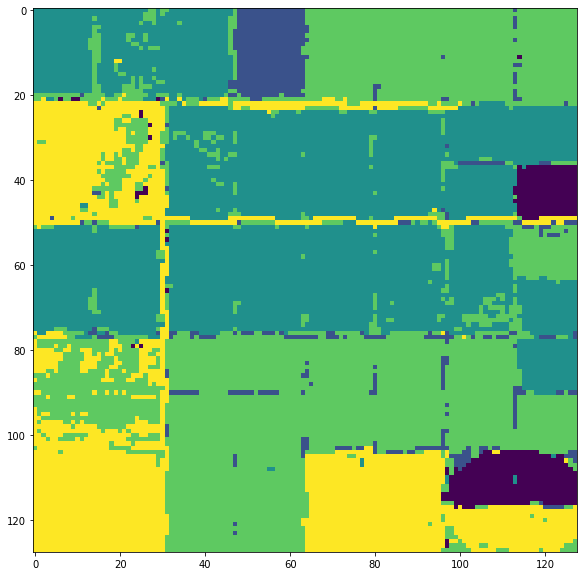

In [22]:
plt.imshow(Ytrain[928, :, :, 0])


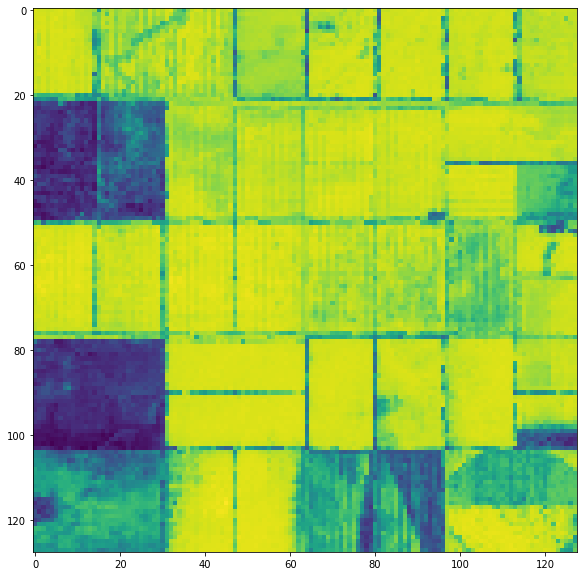

In [23]:
plt.imshow(Xtrain[928,:,:,4])

In [24]:
Xvalid = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Yvalid = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
# train_areas_x = ["Tile_valid_1_2019"]
# train_areas_y = ["gt_valid_1_2019"]

train_areas_x = ["tile_valid_1"]
train_areas_y = ["gt_valid_1"]

for area in range(len(train_areas_x)):
    X_toadd = gridwise_sample(image_tiles[train_areas_x[area]], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[train_areas_y[area]], PATCHSIZE)
    Xvalid = np.concatenate((Xvalid, X_toadd), axis=0)
    Yvalid = np.concatenate((Yvalid, Y_toadd), axis=0)
# encode all non-informal settlement classes as one class
# Ytrain[Ytrain!=2] = 1
print("There are %i number of Validation patches" % (Xvalid.shape[0]))

There are 456 number of Validation patches


In [25]:
image_tiles["tile_valid_1"].shape

(1121, 7420, 8)

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adadelta, Adam
import tensorflow_addons as tfa

import tensorflow.python.keras.backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session
import imp, h5py
import pickle
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.compat.v1.Session(config=config))

2022-03-16 14:03:05.958511: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [31]:
NUMBER_BANDS = 8
NUMBER_CLASSES = 5
NUMBER_EPOCHS = 1000  

def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth imaget
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                # if y[h, i, j, 0] != 0:
                Y[h, i, j, y[h, i, j, 0]-1] = 1
                # else:
                #     continue
    return Y


def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

def avg_soft_dice(y_true, y_pred):
    with tf.compat.v1.name_scope('cost'):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = tf.constant(1e-6, dtype=tf.float32)
        intersection = tf.reduce_sum(input_tensor=tf.multiply(y_pred, y_true), axis=[1, 2])
        numerator = tf.multiply(tf.constant(2., dtype=tf.float32), intersection)
        denominator = tf.reduce_sum(input_tensor=tf.add(tf.square(y_pred), tf.square(y_true)), axis=[1, 2])
        dice_mean = tf.reduce_mean(input_tensor=tf.divide(numerator, tf.add(denominator, epsilon)))
        loss = tf.subtract(tf.constant(1., dtype=tf.float32), dice_mean, name='loss')
        return loss


def build_FCN(optimizer, nrows, ncols, nbands):
    """Function to create Keras model of sample network."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(7, 7),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
              pool_size=(3, 3),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(keras.layers.Conv2D(
              filters=NUMBER_CLASSES,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    #model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model


def train(model, data, labels, Xvalid, Yvalid, wts):
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                          patience=30,
                                          verbose = 1,
                                          restore_best_weights=True)
    
    cp = tf.keras.callbacks.ModelCheckpoint(filepath=wts,
                                            monitor='val_loss',
                                            verbose=1,
                                            save_weights_only=True,
                                            mode='auto',
                                            save_best_only=True)
    hist = model.fit(x=data,
                     y=labels,
                     batch_size=64,
                     epochs=NUMBER_EPOCHS,
                     verbose=2,
                     callbacks=[es,cp],
                     validation_data=(Xvalid, Yvalid))
    return hist

# transform target arrays to one-hot encodings
#Ytrain = to_categorical_4d(Ytrain, NUMBER_CLASSES)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# test_area = Xtrain[PATCH_NO]
# model = build_FCNDK6(OPT, test_area.shape[0], test_area.shape[1], NBANDS, NUMBER_CLASSES)
# model.load_weights(weights_pretrained_B)

# model definition

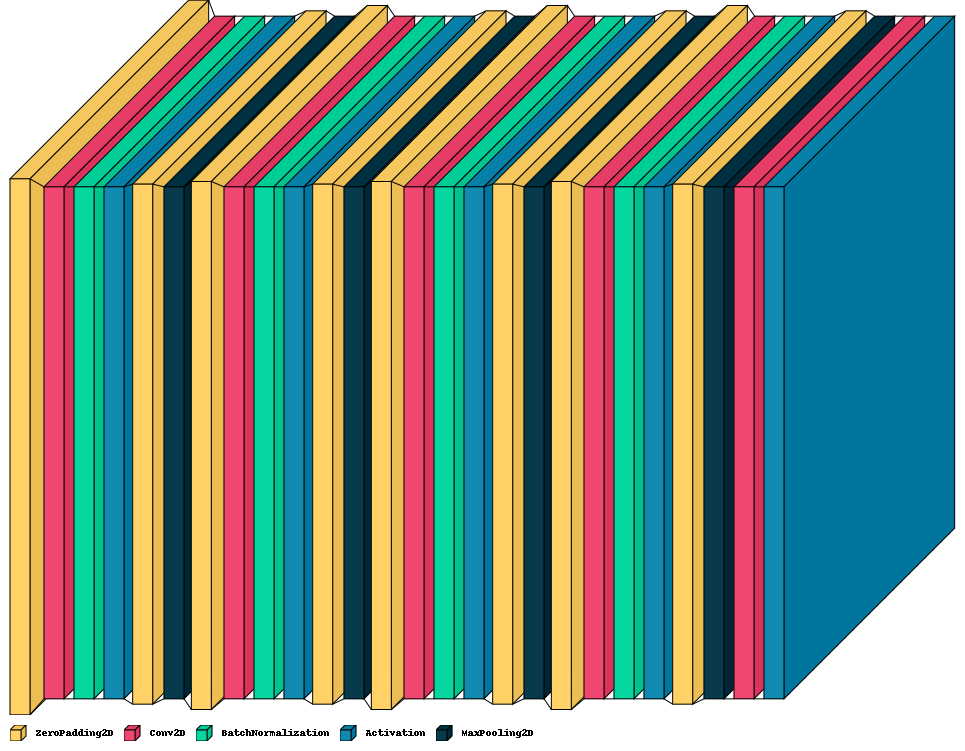

In [87]:
import visualkeras

visualkeras.layered_view(fcn, to_file = 'model_Architecture.png', legend = True)

In [28]:
Ytrain_one_hot = to_categorical_4d(Ytrain, 5)

In [29]:
Yvalid_one_hot = to_categorical_4d(Yvalid, 5)

In [32]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.00007)
checkpoint_filepath = './tmp/checkpoint/weights_fcn_new_soft_dice.hdf5'

fcn = build_FCN(OPT, PATCHSIZE, PATCHSIZE, NUMBER_BANDS)

# fcn.compile(optimizer=OPT, loss= tfa.losses.GIoULoss(), metrics=['acc',f1_m,precision_m, recall_m]) #'adam'
# fcn.compile(optimizer=OPT, loss= jaccard_distance, metrics=['acc',f1_m,precision_m, recall_m]) #'adam'
# fcn.compile(optimizer=OPT, loss= 'npairs_loss', metrics=['acc',f1_m,precision_m, recall_m]) #'adam'
# fcn.compile(optimizer=OPT,loss= 'binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m]) #'adam'
fcn.compile(optimizer=OPT, loss= avg_soft_dice, metrics=['acc',f1_m,precision_m, recall_m]) #'adam'

# model training
history = train(fcn, Xtrain, Ytrain_one_hot, Xvalid, Yvalid_one_hot, checkpoint_filepath)


Epoch 1/1000


2021-11-11 12:19:35.048488: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-11-11 12:19:39.840453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


22/22 - 34s - loss: 0.7249 - acc: 0.3200 - f1_m: 0.2171 - precision_m: 0.4225 - recall_m: 0.1470 - val_loss: 0.7779 - val_acc: 0.0512 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.77790, saving model to ./tmp/checkpoint/weights_fcn_new_soft_dice.hdf5
Epoch 2/1000
22/22 - 15s - loss: 0.6031 - acc: 0.6231 - f1_m: 0.5481 - precision_m: 0.8066 - recall_m: 0.4176 - val_loss: 0.7475 - val_acc: 0.4261 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00002: val_loss improved from 0.77790 to 0.74754, saving model to ./tmp/checkpoint/weights_fcn_new_soft_dice.hdf5
Epoch 3/1000
22/22 - 15s - loss: 0.5591 - acc: 0.7280 - f1_m: 0.6933 - precision_m: 0.8432 - recall_m: 0.5893 - val_loss: 0.7417 - val_acc: 0.2016 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00003: val_loss improved from 0.74754 to 0.74170, saving model to ./tmp/checkpoint/weig

In [33]:
# save the trained network
imp.reload(h5py)
# model_fname = "/home/jovyan/private/AIA_groupProj/trained_fcn_batch64.hdf5"
# fcn.save(model_fname)
train_history_path = './tmp/checkpoint/trainHistoryDict_fcn_soft_dice'
with open(train_history_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [69]:
# train_history_A = train_history_path
train_history_A = './tmp/checkpoint/trainHistoryDict_fcn_soft_dice'
weights_pretrained_A = checkpoint_filepath
# weights_pretrained_A = "./tmp/checkpoint/weights_fcn_new.hdf5"
OPT = tf.keras.optimizers.Adam(learning_rate=0.00007)

# let's visualize the learning curve of the pre-trained network

In [68]:
checkpoint_filepath

'./tmp/checkpoint/weights_fcn_new_soft_dice.hdf5'

In [35]:
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.utils  import load_model
with open(train_history_A, "rb") as f:
    history = pickle.load(f)
# fcn = load_model(weights_pretrained_A)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_16 (ZeroPaddi (None, 134, 134, 8)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      12576     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_10 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 132, 132, 32)     

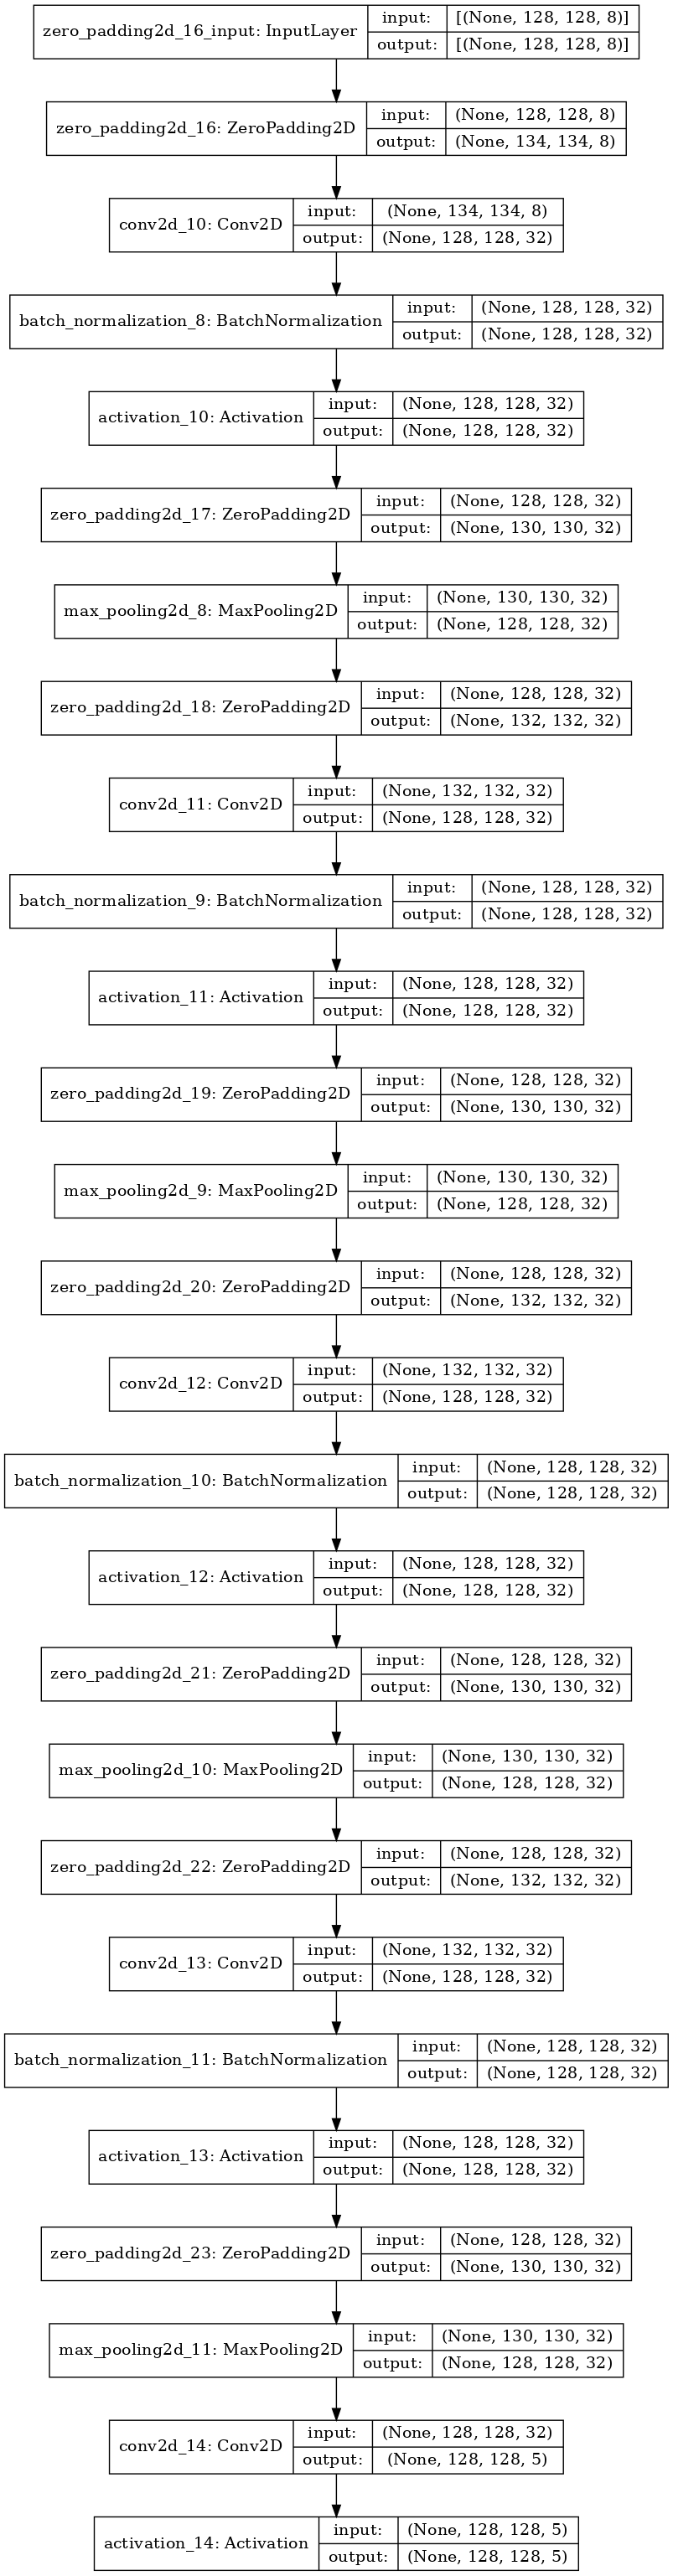

In [31]:
# print(fcn.summary())
# plot_model(fcn, to_file = 'fcn_model_new.png', dpi = 100, show_shapes=True, show_layer_names=True)

In [102]:
history.keys()

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

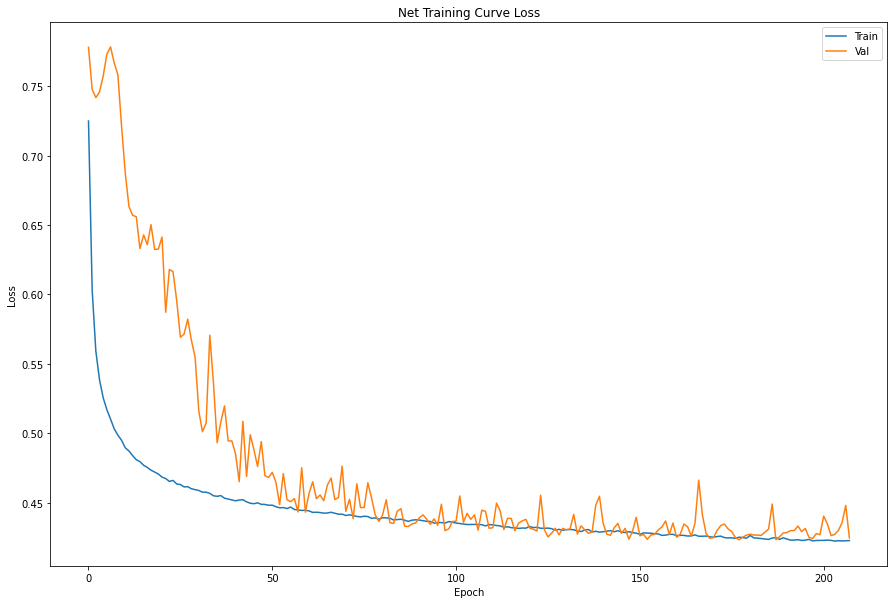

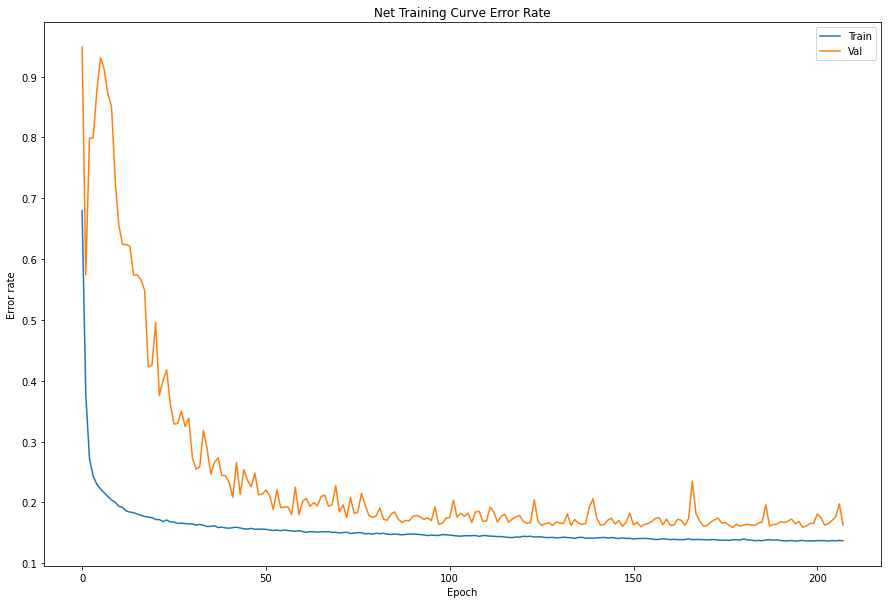

In [36]:
# plot learning curve
plt.plot(history["loss"])
plt.plot(history['val_loss'])
plt.title("Net Training Curve Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('train_val_loss_FCN_softDice.png', dpi=300, transparent = True)
plt.show()
plt.plot(1-np.array(history["acc"]))
plt.plot(1-np.array(history["val_acc"]))
plt.title("Net Training Curve Error Rate")
plt.ylabel("Error rate")
plt.xlabel("Epoch")
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('train_val_error_FCN_softDice.png', dpi=300, transparent = True)
plt.show()


In [38]:
def evaluate_predictions(Xtest, w8fname,
                         cut, overlap, Ytest,
                         model_builder):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    #Ytest[Ytest!=2] = 0
    #Ytest[Ytest==2] = 1
    nrows, ncols, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = model_builder(OPT, sub_nrows, sub_ncols, nbands)
        model.load_weights(w8fname)
        #model.set_weights(wts)
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map




In [70]:
# Xtest = image_tiles["Tile_test_1_2019"]
# Ytest = label_tiles["gt_test_1_2019"]

Xtest = image_tiles["tile_test_1"]
Ytest = label_tiles["gt_test_1"]
print(Xtest.shape, Ytest.shape)

(1121, 7420, 8) (1121, 7420, 1)


In [71]:
# now let's evaluate it on the test tile
cut = 128
overlap = 96
# due to downsampling, SegNet's input spatial dimensions should be
# a factor of 32

# orig_nrows = Xtest.shape[0]
# excess_nrows = orig_nrows%32
# start_row = excess_nrows//2
# orig_ncols = Xtest.shape[1]
# excess_ncols = orig_ncols%32
# start_col = excess_ncols//2
# if excess_nrows!=0:
#     new_nrows = orig_nrows + 32 - excess_nrows
# if excess_ncols!=0:
#     new_ncols = orig_ncols + 32 - excess_nrows
# Xtest_padded = np.zeros((new_nrows, new_ncols, Xtest.shape[2]), dtype=np.float32)
# Ytest_padded = np.zeros((new_nrows, new_ncols, Ytest.shape[2]), dtype=np.float32)
# Xtest_padded[start_row:start_row+orig_nrows,
#              start_col:start_col+orig_ncols, :] = Xtest
# Ytest_padded[start_row:start_row+orig_nrows,
#              start_col:start_col+orig_ncols, :] = Ytest
             
# predictions_SegNet = evaluate_predictions(Xtest_padded, weights_pretrained_C, cut, overlap, Ytest_padded, build_SegNet)
# predictions_SegNet = predictions_SegNet[start_row:start_row+orig_nrows, start_col:start_col+orig_ncols]
predictions_FCN = evaluate_predictions(Xtest=Xtest, w8fname=weights_pretrained_A, cut = cut, overlap=overlap, Ytest=Ytest, model_builder=build_FCN)
# predictions_FCN = predictions_FCN[start_row:start_row+orig_nrows, start_col:start_col+orig_ncols]


Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Strip number: 5
Strip number: 6
Strip number: 7
Last hit!
Strip number: 8
Last hit!


In [41]:
predictions_FCN.shape , Ytest.shape

((1121, 7420), (1121, 7420, 1))

0.83481344871613


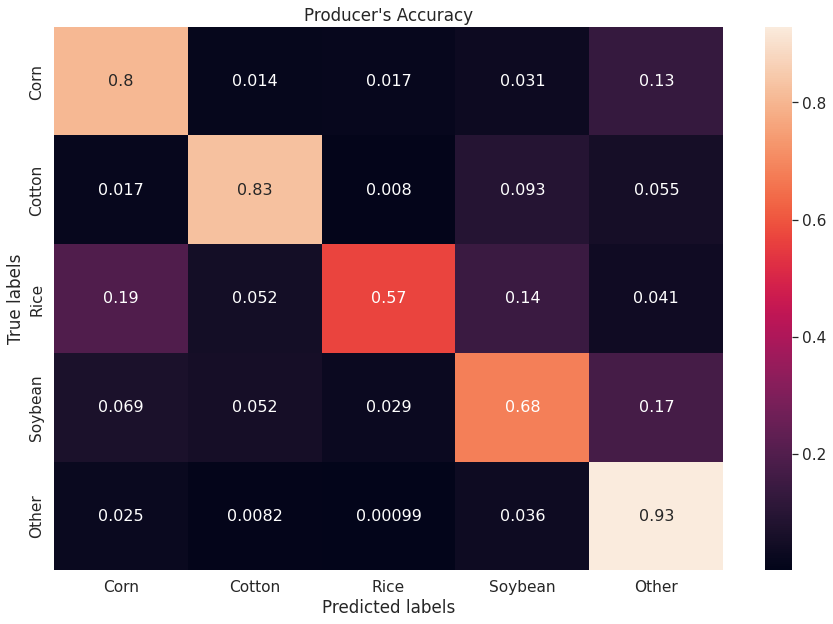

In [72]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
ax = plt.subplot()
sns.set()
a = confusion_matrix(Ytest[:, :, 0].flatten(), (predictions_FCN+1).flatten())
print(accuracy_score(Ytest[:, :, 0].flatten(), (predictions_FCN+1).flatten()))
cm = a.astype('float') / a.sum(axis=1)[:,np.newaxis]

df_cm = pd.DataFrame(cm, range(5), range(5))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, ax = ax, annot_kws={"size": 16},
 xticklabels=['Corn', 'Cotton', 'Rice','Soybean', 'Other'],
 yticklabels=['Corn', 'Cotton', 'Rice','Soybean', 'Other']) # font size

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.title("Producer's Accuracy")
plt.savefig("./soft_dice/conf_mat_new_fcn_19_soft_dice.png", dpi=300, transparent = True)
plt.show()



In [73]:
#lets evaluate the model on 2020 image
FDIR_2020 = "./Input/final_dataset_2020"

image_2020 = fetch_tiles(FDIR_2020)

In [74]:
image_2020.keys()

dict_keys(['Xtest2020', 'Ytest2020'])

In [75]:
image_2020['Xtest2020'].shape, image_2020['Ytest2020'].shape

((5606, 7420, 8), (5606, 7420, 1))

In [76]:
Xtest2020 = image_2020['Xtest2020']
Ytest2020 = image_2020['Ytest2020']

In [77]:
Xtest2020.shape, Ytest2020.shape

((5606, 7420, 8), (5606, 7420, 1))

In [78]:
cut = 128
overlap = 96
             
predictions_FCN_20 = evaluate_predictions(Xtest=Xtest2020, w8fname=weights_pretrained_A, cut = cut, overlap=overlap, Ytest=Ytest2020, model_builder=build_FCN)
# predictions_FCN_20 = predictions_FCN[start_row:start_row+orig_nrows, start_col:start_col+orig_ncols]

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Strip number: 5
Strip number: 6
Strip number: 7
Strip number: 8
Strip number: 9
Strip number: 10
Strip number: 11
Strip number: 12
Strip number: 13
Strip number: 14
Strip number: 15
Strip number: 16
Strip number: 17
Strip number: 18
Strip number: 19
Strip number: 20
Strip number: 21
Strip number: 22
Strip number: 23
Strip number: 24
Strip number: 25
Strip number: 26
Strip number: 27
Strip number: 28
Strip number: 29
Strip number: 30
Strip number: 31
Strip number: 32
Strip number: 33
Strip number: 34
Strip number: 35
Strip number: 36
Strip number: 37
Strip number: 38
Strip number: 39
Strip number: 40
Strip number: 41
Strip number: 42
Strip number: 43
Last hit!


0.7641568813929627


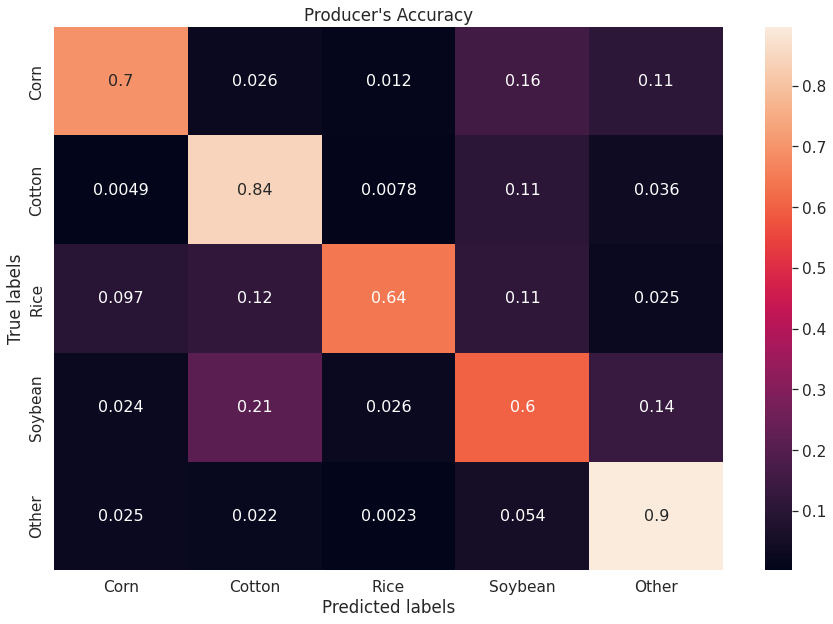

In [79]:
ax = plt.subplot()
sns.set()
a = confusion_matrix(Ytest2020[:, :, 0].flatten(), (predictions_FCN_20+1).flatten())
print(accuracy_score(Ytest2020[:, :, 0].flatten(), (predictions_FCN_20+1).flatten()))
cm = a.astype('float') / a.sum(axis=1)[:,np.newaxis]

df_cm = pd.DataFrame(cm, range(5), range(5))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, ax = ax, annot_kws={"size": 16},
 xticklabels=['Corn', 'Cotton', 'Rice','Soybean', 'Other'],
 yticklabels=['Corn', 'Cotton', 'Rice','Soybean', 'Other']) # font size

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.title("Producer's Accuracy")
plt.savefig("./soft_dice/conf_mat_new_fcn_20_soft_dice.png", dpi=300, transparent = True)
plt.show()

In [118]:
predictions_FCN_20.shape , Ytest2020.shape

((5606, 7420), (5606, 7420, 1))

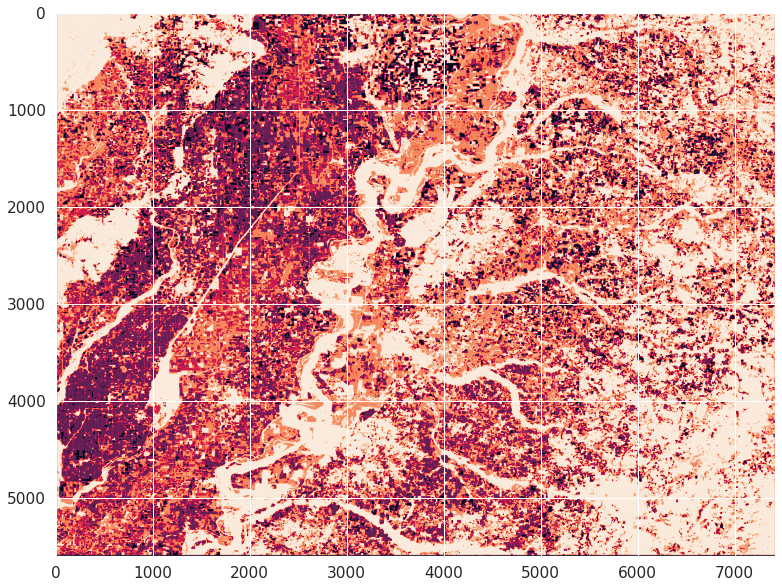

In [119]:
plt.imshow(predictions_FCN_20+1)

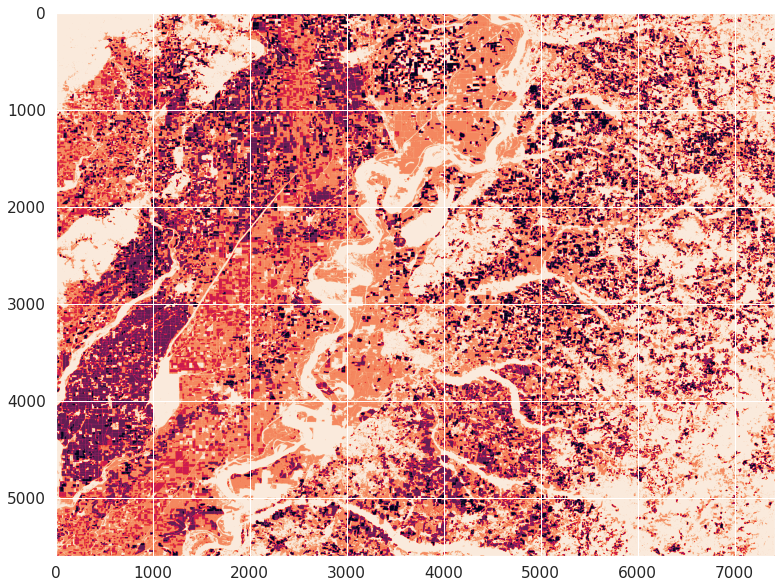

In [120]:
plt.imshow(Ytest2020[:,:,0])

In [28]:
import rasterio
gt = rasterio.open("./Input/final_dataset_2020/Ytest2020.tif", "r")
gt_2019 = rasterio.open("./Input/final_dataset/ground_truth/gt_test_1.tif")

In [30]:
dataset = rasterio.open("./Output/predicted_fcn_new_soft_dice.tif","w",
                driver=gt.driver, width= 7420, height = 5606,
                transform=gt.transform, crs=gt.crs, count=1, dtype=np.uint8)

dataset_2019 = rasterio.open("./Output/predicted_fcn_new_19_CrossEnt.tif","w",
                driver=gt_2019.driver, width= 7420, height = 1121,
                transform=gt_2019.transform, crs=gt_2019.crs, count=1, dtype=np.uint8)

In [31]:
dataset.write((predictions_FCN_20+1).reshape(1,predictions_FCN_20.shape[0],predictions_FCN_20.shape[1]))
dataset.close()

dataset_2019.write((predictions_FCN+1).reshape(1,predictions_FCN.shape[0],predictions_FCN.shape[1]))
dataset_2019.close()


In [33]:
gt_2019.transform

Affine(0.0002694945851752015, 0.0, -90.404923058,
       0.0, -0.00026949458526578425, 35.795887779082946)